# Desarrollo de un modelo de análisis de sentimientos a partir de datos recuperados por twipper

**por Álvaro Bartolomé del Canto @ alvarob96 en GitHub**

---
## Introducción

A lo largo de este informe, se presentará el proceso de creación de un modelo de análisis de sentimientos en español, en base a los tweets previamente extraídos con [twipper](https://github.com/alvarob96/twipper) y categorizados de forma supervisada a través de la plataforma **tcue_sentiment**.

Para la creación de este modelo, primero se hará un análisis exploratorio de los datos, es decir, de los tweets originales ya etiquetados e insertados en un `pandas.DataFrame` (recuperados de **MongoDB**, ya que este es el sistema de almacenamiento propio de **tcue_platform**). Después, se hará uso del modelo de lenguaje creado para el español, que se basa en la limpieza y tokenización del texto de entrada, lo cual a su vez, más adelante, servirá de entrada al modelado. Finalmente, para crear el modelo, se aplicará un algoritmo de **Feature Extraction**, seguido de un **Classifier**, que sea capaz de clasificar nuevos tweets de entrada en cada una de las categorías determinadas por sentimiento (negativo, neutral y positivo).

Destacar que el punto fuerte de dicha propuesta consiste en la elaboración de un sistema de **NLP en español**, que combinando una serie de técnicas de análisis de lenguaje junto con algoritmos de **Machine Learning**, darán lugar a la creación de un **modelo de análisis de sentimientos en español**.

---
## Recuperación de los Datos

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
import pickle

De este modo, inicialmente se procederá a la carga de los datos a través de [pickle](https://docs.python.org/3/library/pickle.html), que es un sistema para la serialización de objetos en Python que almacena su contenido sobre un fichero de texto, que posteriomente, podrá ser leido directamente sobre un objeto de Python de igual forma.

In [21]:
with open('resources/sentiment.pickle', 'rb') as pick:
    df = pickle.load(pick)

In [22]:
df.head()

,sentiment,tweet
0,positive,Impresionante como siempre la última temporada...
1,neutral,"Esta acción, que hasta ahora se tenía que inte..."
2,neutral,"Ladran, Sancho, señal que cabalgamos Bona nit!"
3,neutral,Se q alguien cuando lo lea se le caeran lágrim...
4,positive,Bueno toca descansar mañana pa Córdoba


---
## Análisis Exploratorio de los Datos

Para realizar el análisis exploratorio de los datos, dado que el `pandas.DataFrame` tan solo contiene dos columnas, seré breve. De este modo, se calculará y analizará la longitud de cada uno de los tweets ya clasificados y se buscará una posible correlación entre la longitud de un tweet para con el sentimiento con el que se ha categorizado de forma supervisada previamente a través de la plataforma **tcue_sentiment**.

In [23]:
df['tweet_length'] = df['tweet'].str.len()

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

Se mostrará la distribución de la longitud de los tweets de entre todos los tweets contenidos en el `pandas.DataFrame`, para así poder determinar cúal es la longitud "normal" de un tweet.

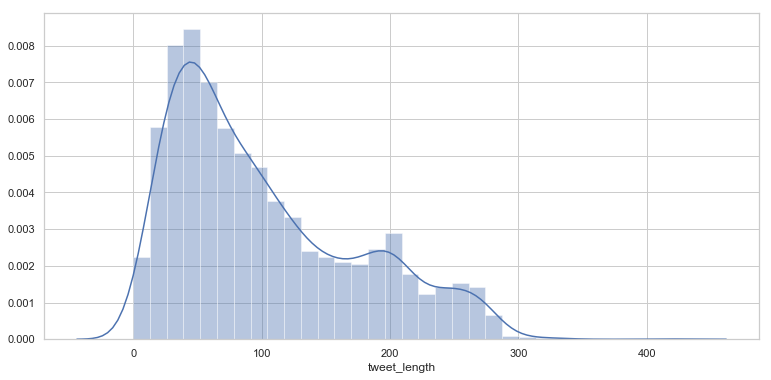

In [25]:
plt.figure(figsize=(12.8,6))

sns.distplot(df['tweet_length'])

De la distribución anterior, se determina que la longitud de un tweet por lo general suele estar por debajo de los 100 caracteres, lo cual implica que la mayoría de tweets son opiniones directas y ausentes de un gran contenido, con lo que las palabras relevantes, de cara al modelado, de cada uno de dichos tweets serán pocas. Es más raro ver tweets con una longitud mayor de 100, pero aún así dichos tweets también están presentes en el `pandas.DataFrame`.

---
Ahora, se mostrará un gráfico de barras con el fin de determinar cúantos tweets se han clasificado de forma supervisada a través de la plataforma **tcue_sentiment**, para así poder determinar la tendencia a la hora de publicar tweets.

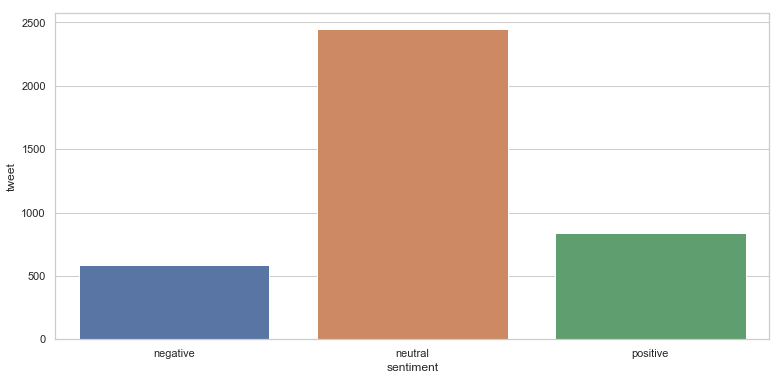

In [44]:
plt.figure(figsize=(12.8,6))

aux = df.groupby('sentiment').count()

sns.barplot(data=aux, x=aux.index, y='tweet')

Tal y como se puede observar en el gráfico de barras previamente mostrado, la cantidad de tweets que han sido categorizados como neutrales es notoriamente superior a los que se han clasificado bien como positivos o bien como negativos, de forma supervisada. Con esto, dadas las muestras tomadas se deduce que la opinión general en Twitter tiene un sentimiento neutral, mientras que la positiva y la negativa van más o menos a la par.

---
Por último, se realizará una representación cruzada de las mencionadas anteriormente, donde se observa la distribución cuantitativa de los datos previamente mencionados comparando así la longitud de un tweet con el sentimiento al que pertenece, con el fin de determinar si el sentimiento está de algún modo relacionado con el tamaño del tweet.

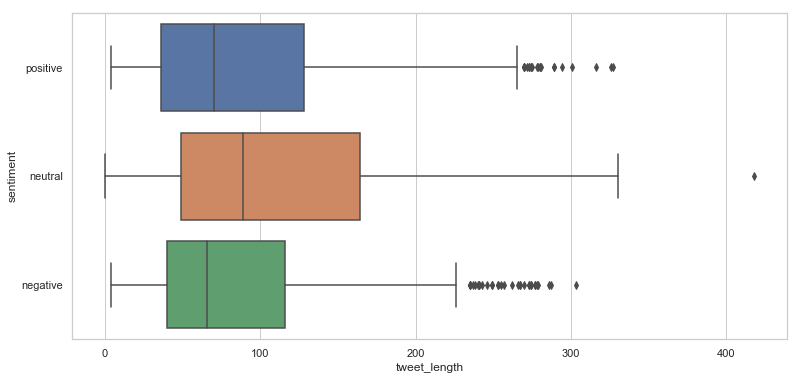

In [45]:
plt.figure(figsize=(12.8,6))

sns.boxplot(data=df, x='tweet_length', y='sentiment')

De esta gráfica extraemos la conclusión de que, por lo general, la longitud de los tweets neutrales suele ser algo mayor que la longitud de los positivos y negativos; aunque dado que hay más tweets neutrales en el `pandas.DataFrame`, el dato tampoco es muy revelador.

---
## Limpieza y Pre-Procesamiento de los Tweets

Ahora, antes de realizar el modelo con los tweets, será necesario limpiarlos y pre-procesarlos de cara a establecer el algoritmo de _Feature Extraction_ a utilizar.

Por tanto, se llevarán a cabo dos tipos de limpieza/pre-procesamiento, que consisten en mantener tan solo las palabras útiles de cara a la creación del modelo, lo cual implica la eliminación de *stopwords* o palabras irrelevantes que se producen con mucha frecuencia en el lenguaje español y que no aportan ningun significado útil de cara a la creación del modelo.

In [46]:
def get_stopwords():
    stopwords_list = list()

    with open('resources/stopwords-es.txt', 'rt', encoding='utf-8') as stopwords:
        for stopword in stopwords.readlines():
            stopwords_list.append(stopword.strip())

        stopwords.close()
        
    return stopwords_list

Además, se realizará un proceso de limpieza de palabras que no se requieren para el modelo, como lo son las URL, los tags HTML o los espacios múltiples que serán eliminados. También se aplicará una expresión regular de cara a buscar solo las palabras, de modo que se insertarán en una lista. Dicha lista será el resultado de la tokenización del tweet de entrada, que será utilizado más adelante para el proceso de _Feature Extraction_.

In [47]:
import re

In [48]:
def tokenizer(tweet, stopwords_list):
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    spaces_pattern = re.compile('[ ]{2,}')
    
    result = url_pattern.sub('', tweet)
    result = html_pattern.sub('', result)
    result = spaces_pattern.sub('', result)
    result = re.findall('\w+', result)
    
    result = ' '.join([word.lower() for word in result if word.lower() not in stopwords_list])
    
    return result

Entonces el resultado de la tokenización de cada uno de los tweets originales de la colección original, será insertado en una nueva columna en la fila correspondiente del `pandas.DataFrame` de forma que, no tan solo contendrá el tweet original, sino el tweet tokenizado separado por espacios con las únicas palabras relevantes para la creación del modelo.

In [49]:
stopwords_list = get_stopwords()

In [50]:
results = [tokenizer(tweet, stopwords_list) for tweet in df['tweet']]

In [51]:
df['tokenized'] = results

In [52]:
df.head()

,sentiment,tweet,tweet_length,tokenized,sentiment_code
0,positive,Impresionante como siempre la última temporada...,120,impresionante temporada blackmirror corta inte...,1
1,neutral,"Esta acción, que hasta ahora se tenía que inte...",191,acción intereumpir mostrar cartulina reglas to...,0
2,neutral,"Ladran, Sancho, señal que cabalgamos Bona nit!",46,ladran sancho señal cabalgamos bona nit,0
3,neutral,Se q alguien cuando lo lea se le caeran lágrim...,85,alguien lea caeran lágrimas puños jajaja lella...,0
4,positive,Bueno toca descansar mañana pa Córdoba,38,toca descansar mañana pa córdoba,1


---
## Modelo de Análisis de Sentimiento

### Preparación de las Etiquetas

A lo largo de esta fase, de cara a preparar los datos para crear el modelo de análisis de sentimientos, se etiquerán los distintos sentimientos (**negativo, neutral y positivo**) con números, con el fin de fecilitar el algoritmo de clasificación dado que tanto la entrada como la salida son números enteros.

Dado que los tweets ya están etiquetados por sentimientos, tan solo será necesario alterar el `pandas.DataFrame` añadiendo una nueva columna que contendrá el código del sentimiento. De este modo, los tweets etiquetados de forma supervisada como negativos y tras ser debidamente tokenizados, serán de la forma:

In [53]:
df[df['sentiment'] == 'negative']['tokenized'].tolist()[:2]

['servicio unicajabanco visto años', 'poto']

Se establece el sistema de numeración por las etiquetas, donde cada sentimiento será un número comprendido entre -1 y 1, para los sentimientos negativo, neutral y positivo, respectivamente.

In [54]:
sentiment_codes = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
}

In [55]:
df['sentiment_code'] = df['sentiment']
df = df.replace({'sentiment_code': sentiment_codes})

In [56]:
df.head()

,sentiment,tweet,tweet_length,tokenized,sentiment_code
0,positive,Impresionante como siempre la última temporada...,120,impresionante temporada blackmirror corta inte...,1
1,neutral,"Esta acción, que hasta ahora se tenía que inte...",191,acción intereumpir mostrar cartulina reglas to...,0
2,neutral,"Ladran, Sancho, señal que cabalgamos Bona nit!",46,ladran sancho señal cabalgamos bona nit,0
3,neutral,Se q alguien cuando lo lea se le caeran lágrim...,85,alguien lea caeran lágrimas puños jajaja lella...,0
4,positive,Bueno toca descansar mañana pa Córdoba,38,toca descansar mañana pa córdoba,1


Ahora se divide el dataset previamente creado como un `pandas.DataFrame` en **train** y **test** en 90% y 10%, de modo que el modelo resultante tomará como datos de entrada el 90% de los tweets clasificados en positivo, negativo o neutral de forma supervisada, mientras que el 10% restante será utilizado para probar la precisión del algoritmo.

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized'],
                                                    df['sentiment_code'],
                                                    test_size=0.10)

---
### Feature Extraction

Una vez disponemos del listado de *tokens* o palabras relevantes del documento tras la limpieza y el pre-procesamiento, se procederá a la implementación del modelo de **TF-IDF** (*Term Frequency - Inverse Document Frequency*), a través del cual se obtendrán las palabras clave o *keywords* con una mayor frecuencia de aparición a lo largo del documento.

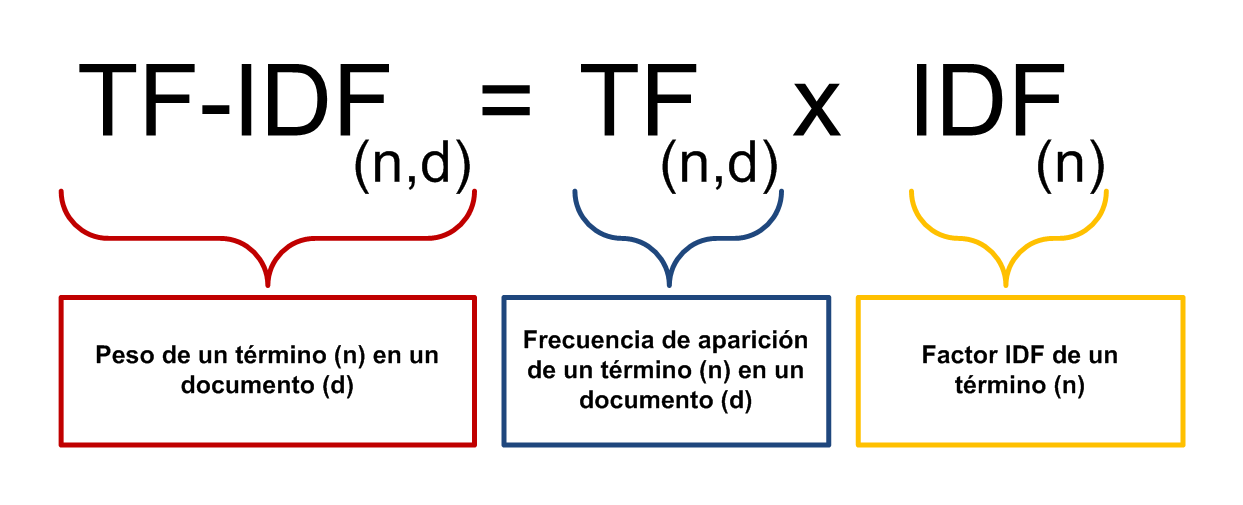

In [59]:
from IPython.display import Image
Image(filename='resources/tfidf.png') 

Se utilizará la biblioteca [scikit-learn](https://scikit-learn.org/stable/) para la implementación del algoritmo **TF-IDF**. Es decir, se realizará un proceso de _Feature Extraction_ sobre los tweets ya tokenizados de entrada, para así convertir cada una de las palabras o tokens en números, junto con su frecuencia de aparición en cada tweet y a lo largo de toda la colección de tweets.

Referencia TfidfVectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        max_features=10000,
                        norm='l2',
                        sublinear_tf=True)

Una vez se ha ajustado el algoritmo con los datos de entrada, en este caso una lista de *tokens* extraidos y pre-procesados a partir del resultado de *Twitter*, se procede a la definición de una función para la obtención de los N términos más relevantes, es decir, aquellos con una mayor frecuencia de aparación; junto con la creación de las variables que servirán de entrada al algoritmo de clasificación que dará lugar a la creación de un modelo de análisis de sentimientos.

In [72]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train

In [107]:
import pickle

In [106]:
with open('resources/tfidf.pickle', 'wb') as file_:
    pickle.dump(tfidf, file_)

In [73]:
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test

In [74]:
from sklearn.feature_selection import chi2
import numpy as np

In [75]:
for sentiment, sentiment_id in sorted(sentiment_codes.items()):
    features_chi2 = chi2(features_train, labels_train == sentiment_id)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    
    print("\n# Categoría '{}':".format(sentiment))
    print(". {}".format('\n. '.join(unigrams[-5:])))


# Categoría 'negative':
. asco
. heterótrofa
. triste
. puta
. mierda

# Categoría 'neutral':
. amo
. puta
. feliz
. gracias
. mierda

# Categoría 'positive':
. abrazo
. enhorabuena
. amo
. feliz
. gracias


De esta forma, podemos comprobar de forma supervisada las _features_ extraídas tras aplicar **TF-IDF**, con el fin de ver si los datos recuperados, limpiados, pre-procesados son válidos en base a los sentimientos para con los cuales se relacionan las palabras principales de cada uno de estos sentimientos.

---
### Algoritmo de Clasificación

El algoritmo elegido para la creación del modelo es, obviamente, un modelo de clasificación, dado que la entrada del algoritmo será el resultante de aplicar **TfidfVectorizer** a una colección de tweets etiquetados en base a la clasificación supervisada de los mismos en sentimientos (positivo, negativo o neutral). Por tanto, se utilizará el algoritmo **RandomForestClassifier**, que es un estimador que se ajusta a un número de clasificadores de árboles de decisión en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y el problema de sobre-muestreo. El tamaño de la submuestra es siempre el mismo que el tamaño original de la muestra de entrada, pero las muestras se extraen con reemplazo si bootstrap=True (por defecto).

Referencia RandomForestClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

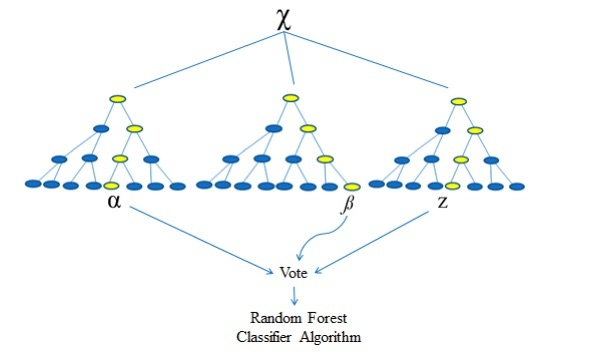

In [76]:
from IPython.display import Image
Image(filename='resources/randomforest.jpg') 

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
forest = RandomForestClassifier()

In [79]:
forest.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Por tanto, en base a los parámetros aceptados por **RandomForestClassifier**, se procede a la creación de un diccionario con los posibles valores de los mismos en una lista, con el que se realizará una validación cruzada con el fin de probar todas y cada una de las posibles combinaciones de los mismos, lo cual ayudará a determinar cúal es la mejor combinación de híper-parámetros para obtener el procentaje de precisión más alto.

In [80]:
params = {
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100],
}

Para realizar la validación cruzada de los algoritmos implementados por **sklearn**, se puede hacer uso de la utilidad **GridSearchCV**, que dado un diccionario con los valores de los híper-parámetros a probar, realiza el proceso de validación cruzada de los mismos dado un mismo dataset, de modo que se obtiene la mejor combinación para cada dataset individual.

In [81]:
from sklearn.model_selection import GridSearchCV

In [86]:
gridsearch = GridSearchCV(estimator=forest,
                          param_grid=params,
                          cv=2,
                          n_jobs=1)

In [87]:
gridsearch.fit(features_train, labels_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Tras la conclusión del **GridSearchCV** se pueden observar tanto los mejores híper-parámetros como los resultados de la validación cruzada. En este caso, tan solo haremos uso de los mejores híper-parámetros con el fin de utilizarlos a la hora de crear el modelo de clasificación de tweets en sentimientos.

In [88]:
gridsearch.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'log2',
 'n_estimators': 100}

In [89]:
gridsearch.cv_results_['mean_test_score']

array([0.65432099, 0.65604364, 0.66006316, 0.65920184, 0.65719208,
       0.65661786])

---
### Persistencia del Modelo

Ahora, dado que ya se conocen los mejores híper-parámetros para el algoritmo **RandomForestClassifier** para la clasificación de texto en sentimientos, se procede a la creación del modelo.

In [98]:
random_forest = RandomForestClassifier(bootstrap=True,
                                       criterion='gini',
                                       max_features='log2',
                                       n_estimators=100)

In [99]:
random_forest.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
prediction = random_forest.predict(features_test)

In [101]:
random_forest.score(features_test, labels_test)

0.6382428940568475

Con el fin de mantener la persistencia del modelo, se guardará dicho modelo en un fichero [pickle](https://docs.python.org/3/library/pickle.html), que permite la persistencia de objetos de Python en ficheros de texto, de forma que de igual modo que permite la escritura, permite la lectura posterior del mismo con el fin de evitar tener que entrenar el modelo una y otra vez.

In [108]:
import pickle

In [105]:
with open('resources/sentiment_model.pickle', 'wb') as file_:
    pickle.dump(random_forest, file_)

---
## Licencia

MIT License

Copyright (c) 2019 Álvaro Bartolomé del Canto

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---
## Autor

**Álvaro Bartolomé del Canto, 2018-2019**